In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Libraries**

In [ ]:
import keras_preprocessing
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

In [ ]:
%cd /content/gdrive/"My Drive"/"Covid19"

/content/gdrive/My Drive/Covid19


**Fetch Dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Covid19"

**Split dataset into train and Test data**

In [ ]:
disease=['COVID', 'non-COVID']
Data_dir = '/content/gdrive/MyDrive/cv_project/Covid19'
train_set_dir = os.path.join(Data_dir)

In [ ]:
train_set_data = []
for defects_id, sp in enumerate(disease):
    for file in os.listdir(os.path.join(train_set_dir, sp)):
        train_set_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train_set = pd.DataFrame(train_set_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
Img_size = 150
def read_image(file_path):
    return cv2.imread(os.path.join(Data_dir, file_path))
def resize_image(image, Img_size):
    return cv2.resize(image.copy(), Img_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train_set = np.zeros((train_set.shape[0], Img_size, Img_size, 3))
for i, file in tqdm(enumerate(train_set['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train_set[i] = resize_image(image, (Img_size, Img_size))
X_train_set = X_train_set / 255.
print(X_train_set.shape)

2481it [00:20, 123.34it/s]


(2481, 150, 150, 3)


In [ ]:
Y_train_set = train_set['DiseaseID'].values
Y_train_set = to_categorical(Y_train_set, num_classes=2)

In [ ]:
X_train_set, X_value, Y_train_set, Y_value = train_test_split(X_train_set, Y_train_set, test_size=0.1)

**Define VGG16 Model**

In [ ]:
def build_VGG16():
  vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
  x = vgg16_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  Predict = Dense(2, activation = 'softmax')(x)
  model = Model(vgg16_model.input,Predict)
  for layer in vgg16_model.layers:
      layer.trainable = False
  optimizer = Adam(learning_rate=0.0002)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model._name = "VGG16_Architecture"
  model.summary()
  return model

**Train the model**

In [ ]:
Model = build_VGG16()
train_seting_datagen = ImageDataGenerator(rotation_range=40, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

train_set_generator = train_seting_datagen.flow(
	X_train_set, Y_train_set,
batch_size=64
)
train_seting_datagen.fit(X_train_set)


file_path="VGG16_Model.hdf5"
checkpoint = callbacks.ModelCheckpoint(file_path, monitor='value_Loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

history = Model.fit(train_set_generator, steps_per_epoch=32, epochs=25,
                              validation_data=(X_value, Y_value),validation_steps=50,callbacks=callbacks_list)

58900480/58889256 [==============================] - 0s 0us/step
Model: "VGG16_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                 

**Plot the results**

In [ ]:
accuracy = history.history['accuracy']
value_accuracy = history.history['val_accuracy']
Loss = history.history['loss']
value_Loss = history.history['val_loss']
 

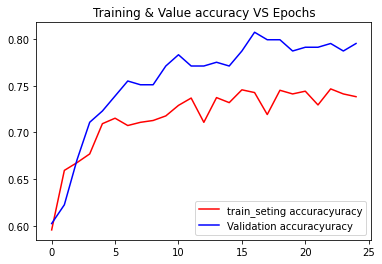

<Figure size 432x288 with 0 Axes>

In [ ]:

Epochs = range(len(accuracy))
plt.plot(Epochs, accuracy, 'r', label='train_seting accuracyuracy')
plt.plot(Epochs, value_accuracy, 'b', label='Validation accuracyuracy')
plt.title('Training & Value accuracy VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

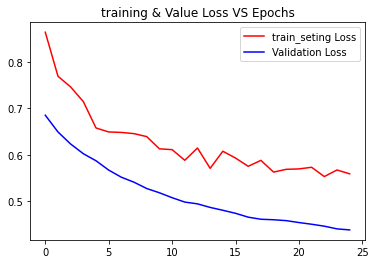

<Figure size 432x288 with 0 Axes>

In [ ]:

Epochs = range(len(accuracy))
plt.plot(Epochs, Loss, 'r', label='train_seting Loss')
plt.plot(Epochs, value_Loss, 'b', label='Validation Loss')
plt.title('training & Value Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
Model.load_weights("VGG16_Model.hdf5")
score = Model.evaluate(X_value, Y_value ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

8/8 [==============================] - 55s 7s/step - loss: 0.4462 - accuracy: 0.7992
Test Loss: 0.44622641801834106
Test accuracy: 79.91967797279358


Text(0.5, 1.0, 'Confusion Matrix')

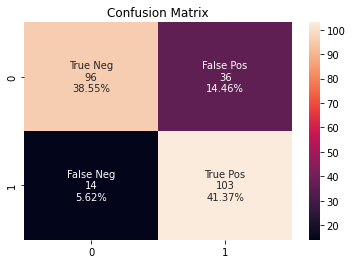

In [ ]:
Y_predict = Model.predict(X_value)
Y_predictx = np.argmax(Y_predict, axis = -1)
Y_valuex = np.argmax(Y_value, axis = -1)
cf_matrix = confusion_matrix(Y_valuex, Y_predictx)
group_name = ['True Neg','False Pos','False Neg','True Pos']
group_count = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentage = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
label = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_name,group_count,group_percentage)]
label = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")